In [1]:
import os, sys, re, gc, glob

# set working dir
WORKING_DIR = re.sub('jdi-qasp-ml.*$','',os.path.normpath(os.getcwd())) + 'jdi-qasp-ml'
os.chdir(WORKING_DIR)

import torch
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm, trange
from sklearn.metrics import confusion_matrix
import json

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

from tqdm.auto import tqdm, trange
from utils import JDNDataset, JDIModel, get_grey_image, assign_labels, logger, maximize_window, DatasetBuilder, load_gray_image
from time import sleep
from flask import jsonify

import datetime as dt
import requests

START_DT = dt.datetime.now()

2021-06-22 17:07:13,219 -INFO - config:config.py:16 - Module utils.config was loaded
2021-06-22 17:07:13,221 -INFO - common:common.py:618 - Module utils.common is loaded...
2021-06-22 17:07:13,221 -INFO - hidden:hidden.py:121 - hidden module is loaded
2021-06-22 17:07:13,228 -INFO - features_builder:features_builder.py:305 - feature_bilder module is loaded...
2021-06-22 17:07:13,230 -INFO - dataset_builder:dataset_builder.py:207 - dataset package is loaded...
2021-06-22 17:07:13,233 -INFO - dataset:dataset.py:277 - dataset module is loaded...


In [2]:
SITE_URL = 'https://vk.com'

SAVE_SCREEN = True
WAIT_TIME_SECONDS = 7
HEADLESS = True #False

PREDICT_URL = 'http://localhost:5000/predict'
DATASET_NAME = 'tmp-dummy'


### getting json

2021-06-22 17:07:13,523 -INFO - dataset_builder:dataset_builder.py:77 - Dataset name: tmp-dummy
2021-06-22 17:07:13,523 -INFO - dataset_builder:dataset_builder.py:86 - Create directories to save the dataset
2021-06-22 17:07:13,524 -INFO - dataset_builder:dataset_builder.py:123 - Creating driver
2021-06-22 17:07:14,603 -INFO - dataset_builder:dataset_builder.py:131 - Chrome web driver is created
2021-06-22 17:07:14,718 -INFO - <ipython-input-3-83df88d706b5>:<ipython-input-3-83df88d706b5>:10 - getting url: https://vk.com
2021-06-22 17:07:19,861 -INFO - common:common.py:75 - Window maximized
2021-06-22 17:07:19,862 -INFO - dataset_builder:dataset_builder.py:134 - save scrinshot: dataset/images/tmp-dummy.png
2021-06-22 17:07:19,956 -INFO - dataset_builder:dataset_builder.py:178 - Collect features using JS script
2021-06-22 17:07:20,217 -INFO - dataset_builder:dataset_builder.py:186 - Save html to dataset/html/tmp-dummy.html
2021-06-22 17:07:20,229 -INFO - dataset_builder:dataset_builder.py

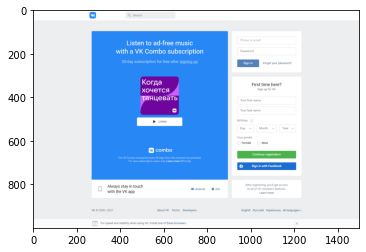

In [3]:
class DSBuilder(DatasetBuilder):
    def setUp(self, driver):
        """
            This method may be overwitten if you need to login to the site
            and navigate to a specific url,
            otherwise it just returns 
        """
        
        driver.set_window_size(width=1500, height=1000)
        logger.info(f'getting url: {self.url}')
        self.driver.get(self.url)
        sleep(3.0)
        maximize_window(driver=driver, extend_pix=0)
        
with DSBuilder(url=SITE_URL, dataset_name=DATASET_NAME, headless=True) as builder:
    plt.imshow(plt.imread(f'dataset/images/{DATASET_NAME}.png'))
    login_df = builder.dataset
    login_json = builder.dataset_json

  

In [4]:
PREDICT_URL

'http://localhost:5000/predict'

### Predict: sending json to backend and getting predictions

In [5]:
%%time

response = requests.post(
    PREDICT_URL, data=json.dumps(login_json)
)

if response.status_code == 200:
    display(json.loads(response.text))
else:
    raise Exception(response.text)

[{'element_id': '2446258772708399603815054257',
  'x': 936.5,
  'y': 699.0,
  'width': 270.0,
  'height': 35.0,
  'predicted_label': 'button',
  'predicted_probability': 0.9999787807,
  'sort_key': 9450.0},
 {'element_id': '9841932130708399608987895409',
  'x': 936.5,
  'y': 646.0,
  'width': 270.0,
  'height': 35.0,
  'predicted_label': 'button',
  'predicted_probability': 0.9958078861,
  'sort_key': 9450.0},
 {'element_id': '5360706227708399601463793266',
  'x': 936.5,
  'y': 444.0,
  'width': 270.0,
  'height': 35.0,
  'predicted_label': 'textfield',
  'predicted_probability': 0.9907616973,
  'sort_key': 9450.0},
 {'element_id': '1490009034708399600263721385',
  'x': 936.5,
  'y': 122.0,
  'width': 270.0,
  'height': 35.0,
  'predicted_label': 'textfield',
  'predicted_probability': 0.9999996424,
  'sort_key': 9450.0},
 {'element_id': '1293548354708399600219530026',
  'x': 936.5,
  'y': 172.0,
  'width': 270.0,
  'height': 35.0,
  'predicted_label': 'textfield',
  'predicted_probabi

Wall time: 2.92 s


In [6]:
response

<Response [200]>

In [7]:
print('Elapsed time:', dt.datetime.now() - START_DT)

Elapsed time: 0:00:10.101663


In [8]:
df = pd.read_parquet(f'dataset/df/{DATASET_NAME}.parquet')[['element_id', 'tag_name']]
df.head()

,element_id,tag_name
0,1408804665708399604851887388,HTML
1,4230414873708399607279519634,HEAD
2,6404555392708399601902003479,META
3,5704785591708399602088425866,LINK
4,9696348157708399605028393631,LINK


In [9]:
predictions_df = pd.DataFrame(json.loads(response.text)).merge(df, on='element_id')
predictions_df

,element_id,x,y,width,height,predicted_label,predicted_probability,sort_key,tag_name
0,2446258772708399603815054257,936.500000,699.0,270.000000,35.0,button,0.999979,9450.000000,DIV
1,9841932130708399608987895409,936.500000,646.0,270.000000,35.0,button,0.995808,9450.000000,BUTTON
2,5360706227708399601463793266,936.500000,444.0,270.000000,35.0,textfield,0.990762,9450.000000,INPUT
3,1490009034708399600263721385,936.500000,122.0,270.000000,35.0,textfield,1.000000,9450.000000,INPUT
4,1293548354708399600219530026,936.500000,172.0,270.000000,35.0,textfield,1.000000,9450.000000,INPUT
5,5686615896708399608076475146,936.500000,398.0,270.000000,35.0,textfield,0.990762,9450.000000,INPUT
6,5048301661708399602251853289,936.500000,398.0,270.000000,35.0,button,0.430597,9450.000000,DIV
7,4215462733708399604980252371,477.000000,493.0,208.000000,39.0,button,0.999912,8112.000000,A
8,3531950105708399609934401513,259.000000,0.0,165.000000,48.0,link,0.999992,7920.000000,A
9,3956590628708399605878568949,424.000000,8.0,230.000000,32.0,textfield,0.999999,7360.000000,INPUT


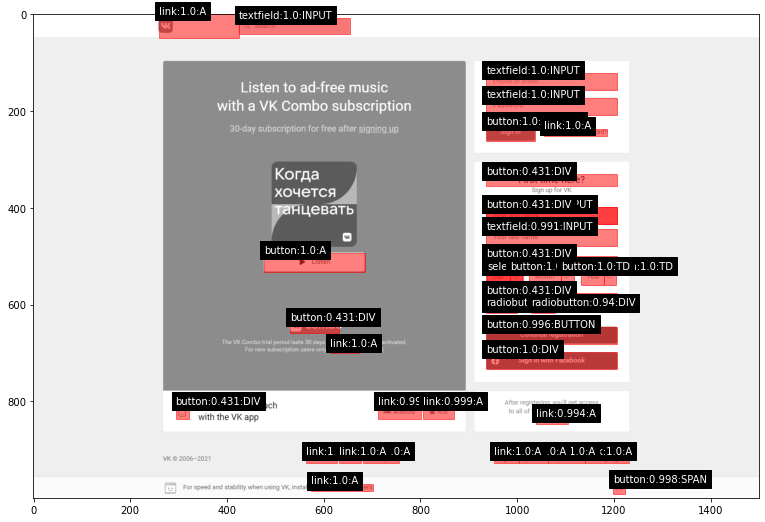

In [10]:
img = load_gray_image(f'dataset/images/{DATASET_NAME}.png')
plt.figure(figsize=(13,300))
plt.imshow(img, cmap='gray')

axes = plt.gca()

for _, r in predictions_df.iterrows():
    patch = Rectangle((r.x, r.y), r.width, r.height, alpha=.5, color='red')
    axes.add_patch(patch)
    
    axes.text(r.x, r.y, 
              r.predicted_label + ':' +str(round(r.predicted_probability, 3)) + ':' + r.tag_name, 
              backgroundcolor='black', 
              color='white')
    